In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared
#from skopt import BayesSearchCV
#from skopt.space import Real, Categorical, Integer
import pickle

%matplotlib inline

In [4]:
# Load the data
df = pd.read_pickle('data.csv')
print('Loaded raw data of shape {}'.format(df.shape))

Loaded raw data of shape (1892, 14)


In [92]:
# # Load the structure data
# structure_descriptors = np.loadtxt("structure_descriptors.txt")
# structure_targets = np.loadtxt("structure_targets.txt")

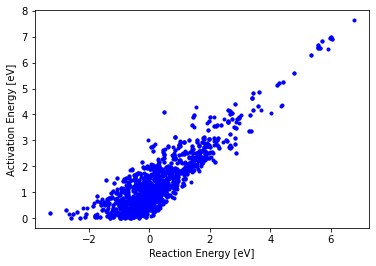

(1892, 14)

In [5]:
plt.plot(df['Reaction Energy'], df['Activation Energy'], 'b.')
plt.xlabel('Reaction Energy [eV]')
plt.ylabel('Activation Energy [eV]')
plt.savefig('../teksti/images/er_ea_correlation.png')
plt.show()
df.shape

In [6]:
df = df.reset_index(drop=True)
df

,Reactant 1,Reactant 2,Reactant 3,Product 1,Product 2,Product 3,Chemical Composition,Surface Composition,Facet,Adsorption Site,Reaction Equation,DFT Functional,Reaction Energy,Activation Energy
0,H2Oaq,H*,None,OHaq,*,H2gas,NaPt27H24O12,Pt,111,None,H2Oaq + H* -> H2(g) + OHaq + *,BEEF-vdW,1.584128,2.079705
1,*,H*,None,*,H2gas,None,NaPt27H24O12,Pt,111,None,H* + * -> H2(g) + 3*,BEEF-vdW,0.520276,0.618718
2,*,CH2C*,None,C*,CH2*,None,Ag30,Ag,111,None,CH2C* + * -> CH2* + C*,BEEF-vdW,3.701011,4.165724
3,N2gas,None,None,N*,None,None,Pt,Pt,211,None,N2(g) -> N*,RPBE,1.350000,2.550000
4,CO2*,None,None,CO2*,None,None,Au27NaH10O5,Au,211,CO2-H2O-topadiabatic,CO2* -> CO2*,RPBE,0.353636,0.482330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1887,CO*,CO*,None,OCCO*,None,None,Cu,None,211,None,None,RPBE,1.164000,1.546000
1888,CO*,CHO*,None,OCCHO*,None,None,Cu,None,211,None,None,RPBE,0.115000,0.675000
1889,CH2O*,CHO*,None,OCHCH2O*,None,None,Cu,None,211,None,None,RPBE,-1.190000,0.374000
1890,CH2O*,CH2O*,None,OCH2CH2O*,None,None,Cu,None,211,None,None,RPBE,-1.265000,0.203000


In [10]:
reaction = df_copy.iloc[np.random.randint(len(df_copy))]
#while reaction["Adsorption Site"] == "None":
#    reaction = df_copy.iloc[np.random.randint(len(df_copy))]
reaction

Reactant 1                   H*
Reactant 2                H2CO*
Reactant 3                 None
Product 1                 H3CO*
Product 2                  None
Product 3                  None
Chemical Composition         Rh
Surface Composition        None
Facet                       211
Adsorption Site            None
Reaction Equation          None
DFT Functional             RPBE
Reaction Energy        -0.04646
Activation Energy       0.67499
Name: 3238, dtype: object

### Separate metals, non-metals, and semiconductors

In [7]:
metals = [
    "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn",
    "Y", "Zr", "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", "Cd",
    "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt", "Au", "Hg",
    "Rf", "Db", "Sg", "Bh", "Hs", "Mt", "Ds", "Rg", "Cn",
    "Al", "Ga", "In", "Sn", "Tl", "Pb", "Bi", "Nh", "Fl", "Mc", "Lv",
    "Y-fcc", "Zr-fcc", "Nb-fcc", "Mo-fcc", "Tc-fcc", "Ru-fcc", "Rh-fcc", "Pd-fcc", "Ag-fcc", "Cd-fcc",
    "Sc-fcc", "Ti-fcc", "V-fcc", "Cr-fcc", "Mn-fcc", "Fe-fcc", "Co-fcc", "Ni-fcc", "Cu-fcc", "Zn-fcc",
    "Hf-fcc", "Ta-fcc", "W-fcc", "Re-fcc", "Os-fcc", "Ir-fcc", "Pt-fcc", "Au-fcc", "Hg-fcc",
    "Rf-fcc", "Db-fcc", "Sg-fcc", "Bh-fcc", "Hs-fcc", "Mt-fcc", "Ds-fcc", "Rg-fcc", "Cn-fcc",
    "Al-fcc", "Ga-fcc", "In-fcc", "Sn-fcc", "Tl-fcc", "Pb-fcc", "Bi-fcc", "Nh-fcc", "Fl-fcc", "Mc-fcc", "Lv-fcc"
]

#df_metals = pd.DataFrame()
indices = []

for i in range(df.shape[0]):
    if df.iloc[i]["Chemical Composition"] in metals or df.iloc[i]["Surface Composition"] in metals:
        indices.append(i)

In [8]:
df_metals = df.iloc[indices]
df_alloys = df.drop(indices)

In [9]:
print(f"df_metals.shape = {df_metals.shape}, df_alloys.shape = {df_alloys.shape}")

df_metals.shape = (1826, 14), df_alloys.shape = (66, 14)


### Transform feature labels to binary one-hot arrays with DataFrameMapper and LabelBinarizer

In [10]:
df_bin = df_metals.copy()
print('Converted', df_bin.shape[1] - 1, 'features into ', end='')

bin_mapper = DataFrameMapper([
    ('Reactant 1', LabelBinarizer()),
    ('Reactant 2', LabelBinarizer()),
    ('Reactant 3', LabelBinarizer()),
    ('Product 1', LabelBinarizer()),
    ('Product 2', LabelBinarizer()),
    ('Chemical Composition', LabelBinarizer()),
    ('Surface Composition', LabelBinarizer()),
    ('Facet', LabelBinarizer()),
    ('Adsorption Site', LabelBinarizer()),
    ('Reaction Equation', LabelBinarizer()),
    (['Reaction Energy'], None),
    (['Activation Energy'], None),
], df_out=True)

df_bin = bin_mapper.fit_transform(df_bin)
print(df_bin.shape[1] - 1, 'features.')
df_bin

Converted 13 features into 528 features.


,Reactant 1_*,Reactant 1_C*,Reactant 1_CCH*,Reactant 1_CCH2*,Reactant 1_CCH3*,Reactant 1_CH*,Reactant 1_CH2*,Reactant 1_CH2CH2*,Reactant 1_CH2CH3*,Reactant 1_CH2N*,...,Reaction Equation_O2(g) -> O*,Reaction Equation_O2* -> O*,Reaction Equation_OCCO* + 0.5H2(g) -> OCCOH*,Reaction Equation_OCH* -> CH* + O*,Reaction Equation_OCH2* -> CH2* + O*,Reaction Equation_OCH3* -> CH3* + O*,Reaction Equation_OH* + * -> H* + O*,Reaction Equation_OH* -> H* + O*,Reaction Energy,Activation Energy
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.584128,2.079705
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.520276,0.618718
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3.701011,4.165724
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.350000,2.550000
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.353636,0.482330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1887,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.164000,1.546000
1888,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.115000,0.675000
1889,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-1.190000,0.374000
1890,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-1.265000,0.203000


### OR Transform feature labels to integer values with LabelEncoder

In [11]:
df_enc = df_metals.copy()

enc_mapper = DataFrameMapper([
    ('Reactant 1', LabelEncoder()),
    ('Reactant 2', LabelEncoder()),
    ('Reactant 3', LabelEncoder()),
    ('Product 1', LabelEncoder()),
    ('Product 2', LabelEncoder()),
    ('Chemical Composition', LabelEncoder()),
    ('Surface Composition', LabelEncoder()),
    ('Facet', LabelEncoder()),
    ('Adsorption Site', LabelEncoder()),
    ('Reaction Equation', LabelEncoder()),
    (['Reaction Energy'], None),
    (['Activation Energy'], None),
], df_out=True)

df_enc = enc_mapper.fit_transform(df_enc)
df_enc = df_enc.drop_duplicates(ignore_index=True)
df_enc

,Reactant 1,Reactant 2,Reactant 3,Product 1,Product 2,Chemical Composition,Surface Composition,Facet,Adsorption Site,Reaction Equation,Reaction Energy,Activation Energy
0,42,46,5,73,0,31,19,6,5,129,1.584128,2.079705
1,0,46,5,0,44,31,19,6,5,117,0.520276,0.618718
2,0,10,5,2,5,2,0,6,5,22,3.701011,4.165724
3,52,58,5,51,52,43,19,7,5,137,1.350000,2.550000
4,30,58,5,33,52,6,2,7,0,109,0.353636,0.482330
...,...,...,...,...,...,...,...,...,...,...,...,...
1821,29,42,5,64,52,10,15,7,5,144,1.164000,1.546000
1822,29,40,5,63,52,10,15,7,5,144,0.115000,0.675000
1823,12,40,5,70,52,10,15,7,5,144,-1.190000,0.374000
1824,12,15,5,68,52,10,15,7,5,144,-1.265000,0.203000


### Split the data into training and test sets

In [12]:
train_set_enc, test_set_enc = train_test_split(df_enc, test_size=0.2)
train_set_bin, test_set_bin = train_test_split(df_bin, test_size=0.2)

y_train_enc = train_set_enc['Activation Energy']
X_train_enc = train_set_enc.drop('Activation Energy', axis=1)
y_train_bin = train_set_bin['Activation Energy']
X_train_bin = train_set_bin.drop('Activation Energy', axis=1)

y_test_enc = test_set_enc['Activation Energy']
X_test_enc = test_set_enc.drop('Activation Energy', axis=1)
y_test_bin = test_set_bin['Activation Energy']
X_test_bin = test_set_bin.drop('Activation Energy', axis=1)

### Linear Regression

In [13]:
linreg_enc = LinearRegression()
linreg_enc.fit(X_train_enc, y_train_enc)
linreg_enc_score = linreg_enc.score(X_test_enc, y_test_enc)
linreg_enc_pred = linreg_enc.predict(X_test_enc)

linreg_bin = LinearRegression()
linreg_bin.fit(X_train_bin, y_train_bin)
linreg_bin_score = linreg_bin.score(X_test_bin, y_test_bin)
linreg_bin_pred = linreg_bin.predict(X_test_bin)

print('LinReg score with label encoded data:', linreg_enc_score)
print('LinReg score with label binarized data:', linreg_bin_score)

LinReg score with label encoded data: 0.8032935873495991
LinReg score with label binarized data: -4.491090624785667e+23


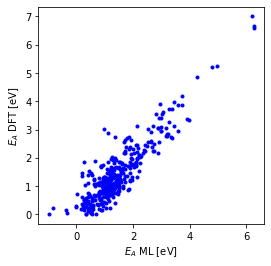

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(linreg_enc_pred, y_test_enc, 'b.')
plt.xlabel('$E_A$ ML [eV]')
plt.ylabel('$E_A$ DFT [eV]')
ax.set_aspect('equal')
plt.savefig('../teksti/images/linreg_enc_pred.png')
plt.show()

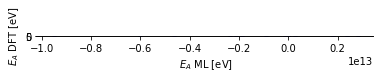

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(linreg_bin_pred, y_test_bin, 'b.')
plt.xlabel('$E_A$ ML [eV]')
plt.ylabel('$E_A$ DFT [eV]')
ax.set_aspect('equal')
plt.savefig('../teksti/images/linreg_bin_pred.png')
plt.show()

### Kernel Ridge Regression

In [21]:
param_grid = {"alpha": [1e0, 1e-1, 1e-2, 1e-3],
              "gamma": np.logspace(-2, 2, 5),
              "kernel": ["rbf", "linear"]}

krr_enc = GridSearchCV(KernelRidge(), param_grid=param_grid)
krr_enc.fit(X_train_enc, y_train_enc)
krr_enc_best = krr_enc.best_estimator_
krr_enc_score = krr_enc_best.score(X_test_enc, y_test_enc)
krr_enc_pred = krr_enc_best.predict(X_test_enc)

krr_bin = GridSearchCV(KernelRidge(), param_grid=param_grid)
krr_bin.fit(X_train_bin, y_train_bin)
krr_bin_best = krr_bin.best_estimator_
krr_bin_score = krr_bin_best.score(X_test_bin, y_test_bin)
krr_bin_pred = krr_bin_best.predict(X_test_bin)

print("KRR score with label encoded data:", krr_enc_score, ", using parameters:", krr_enc_best.get_params())
print("KRR score with label binarized data:", krr_bin_score, ", using parameters:", krr_bin_best.get_params())

KRR score with label encoded data: 0.8033322883757982 , using parameters: {'alpha': 1.0, 'coef0': 1, 'degree': 3, 'gamma': 0.01, 'kernel': 'linear', 'kernel_params': None}
KRR score with label binarized data: 0.9409687605623441 , using parameters: {'alpha': 0.001, 'coef0': 1, 'degree': 3, 'gamma': 0.01, 'kernel': 'rbf', 'kernel_params': None}


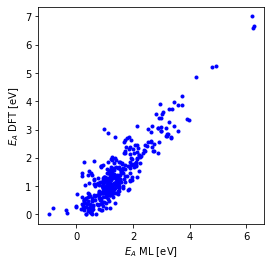

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(krr_enc_pred, y_test_enc, 'b.')
plt.xlabel('$E_A$ ML [eV]')
plt.ylabel('$E_A$ DFT [eV]')
ax.set_aspect('equal')
plt.savefig('../teksti/images/krr_enc_pred.png')
plt.show()

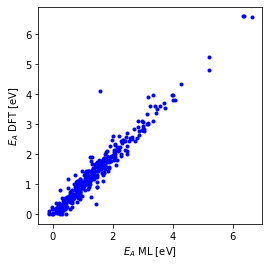

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(krr_bin_pred, y_test_bin, 'b.')
plt.xlabel('$E_A$ ML [eV]')
plt.ylabel('$E_A$ DFT [eV]')
ax.set_aspect('equal')
plt.savefig('../teksti/images/krr_bin_pred.png')
plt.show()

### Random Forest

In [201]:
n_estimators = [50, 100, 150, 200, 250, 300]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [10, 20, 30, 40]
max_depth.append(None)
min_samples_split = [2, 5, 10, 15, 20]
min_samples_leaf = [1, 2, 5, 10, 15, 20]

param_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

rfr_enc = RandomizedSearchCV(RFR(), param_distributions=param_grid, n_iter=400, cv=5, verbose=1, n_jobs=-1)
rfr_enc.fit(X_train_enc, y_train_enc)

rfr_bin = RandomizedSearchCV(RFR(), param_distributions=param_grid, n_iter=400, cv=5, verbose=1, n_jobs=-1)
rfr_bin.fit(X_train_bin, y_train_bin)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Fitting 5 folds for each of 400 candidates, totalling 2000 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=400,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 5, 10, 15,
                                                             20],
                                        'min_samples_split': [2, 5, 10, 15, 20],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300]},
                   verbose=1)

In [202]:
rfr_enc_best = rfr_enc.best_estimator_
rfr_enc_score = rfr_enc_best.score(X_test_enc, y_test_enc)
rfr_enc_pred = rfr_enc_best.predict(X_test_enc)

rfr_bin_best = rfr_bin.best_estimator_
rfr_bin_score = rfr_bin_best.score(X_test_bin, y_test_bin)
rfr_bin_pred = rfr_bin_best.predict(X_test_bin)

print('Random Forest score with label encoded data:', rfr_enc_score, ', using parameters: ', rfr_enc_best.get_params())
print('Random Forest score with label binarized data:', rfr_bin_score, ', using parameters: ', rfr_bin_best.get_params())

Random Forest score with label encoded data: 0.9056872879770731 , using parameters:  {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Random Forest score with label binarized data: 0.9178449089664806 , using parameters:  {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 250, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


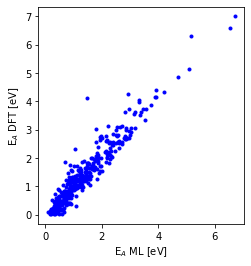

In [203]:
#plt.plot(X_test[key], rfr_pred, 'bo', label='predicted')
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(rfr_enc_pred, y_test_enc, 'b.')
plt.xlabel('E$_A$ ML [eV]')
plt.ylabel('E$_A$ DFT [eV]')
ax.set_aspect('equal')
plt.savefig('../teksti/images/rfr_enc_pred.png')
plt.show()

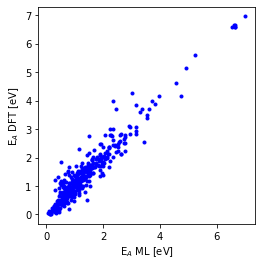

In [204]:
#plt.plot(X_test[key], rfr_pred, 'bo', label='predicted')
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(rfr_bin_pred, y_test_bin, 'b.')
plt.xlabel('E$_A$ ML [eV]')
plt.ylabel('E$_A$ DFT [eV]')
ax.set_aspect('equal')
plt.savefig('../teksti/images/rfr_bin_pred.png')
plt.show()

### Save the trained models

In [205]:
# Save the label encoded RFR model
with open('rfr_enc.pkl', 'wb') as rfr_enc_file:
    pickle.dump(rfr_enc_best, rfr_enc_file)
    
# Save the label binarized RFR model
with open('rfr_bin.pkl', 'wb') as rfr_bin_file:
    pickle.dump(rfr_bin_best, rfr_bin_file)
    
# Save the label encoded KRR model
with open('krr_enc.pkl', 'wb') as krr_enc_file:
    pickle.dump(krr_enc_best, krr_enc_file)
    
# Save the label binarized KRR model
with open('krr_bin.pkl', 'wb') as krr_bin_file:
    pickle.dump(krr_bin_best, krr_bin_file)

### Load the trained models

In [31]:
with open('rfr_enc.pkl', 'rb') as rfr_enc_file:
    rfr_enc_best = pickle.load(rfr_enc_file)
with open('rfr_bin.pkl', 'rb') as rfr_bin_file:
    rfr_bin_best = pickle.load(rfr_bin_file)
with open('krr_enc.pkl', 'rb') as krr_enc_file:
    krr_enc_best = pickle.load(krr_enc_file)
with open('krr_bin.pkl', 'rb') as krr_bin_file:
    krr_bin_best = pickle.load(krr_bin_file)

## Inspect the freature importances

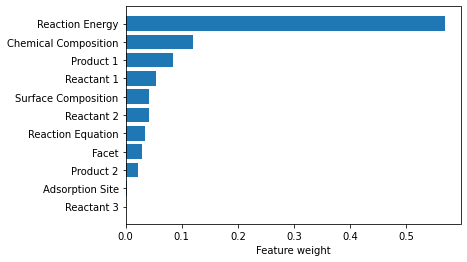

In [38]:
fimportances = rfr_enc_best.feature_importances_
fi_data = np.array([X_train_enc.columns,fimportances]).T
fi_data = fi_data[fi_data[:,1].argsort()]

plt.barh(fi_data[:,0], fi_data[:,1])
plt.xlabel('Feature weight')
plt.savefig('../teksti/images/feature_importances.png', bbox_inches='tight')
#plt.show()

In [221]:
test_reaction = df_copy.loc[0:0].copy()

#print(enc_mapper.features[9][1])
#print(enc_mapper.features[7][1].classes_[20])

test_reaction["Reactant 1"] = "H2O"
test_reaction["Reactant 2"] = "None"
test_reaction["Reactant 3"] = "None"
test_reaction["Product 1"] = "H*"
test_reaction["Product 2"] = "OH*"
test_reaction["Product 3"] = "None"
test_reaction["Chemical Composition"] = "Fe"
test_reaction["Surface Composition"] = "Fe"
test_reaction["Facet"] = "100"
test_reaction["Adsorption Site"] = "None"
#test_reaction["Reaction Equation"] = "H2O -> H* + OH*"
test_reaction["DFT Functional"] = "RPBE"
test_reaction["Reaction Energy"] = 0.39
test_reaction["Activation Energy"] = 0.35

test_reaction = enc_mapper.transform(test_reaction)
test_reaction["Reaction Equation"] = 21
test_reaction

,Reactant 1,Reactant 2,Reactant 3,Product 1,Product 2,Chemical Composition,Surface Composition,Facet,Adsorption Site,Reaction Equation,Reaction Energy,Activation Energy
0,42,58,5,36,54,22,7,4,8,21,0.39,0.35


In [222]:
y_test_reaction = test_reaction['Activation Energy']
X_test_reaction = test_reaction.drop('Activation Energy', axis=1)

test_reaction_prediction = rfr_enc_best.predict(X_test_reaction)
print("Prediction:\t", test_reaction_prediction[0])
print("Target:\t\t", y_test_reaction[0])

Prediction:	 0.8001151354430885
Target:		 0.35


### Train the model with LMBTR descriptors

In [230]:
X_train_struct, X_test_struct, y_train_struct, y_test_struct = train_test_split(structure_descriptors, structure_targets, test_size=0.2)

In [18]:
n_estimators = [50, 100, 150, 200, 250, 300]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [10, 20, 30, 40]
max_depth.append(None)
min_samples_split = [2, 5, 10, 15, 20]
min_samples_leaf = [1, 2, 5, 10, 15, 20]

param_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

#rfr_enc = RandomizedSearchCV(RFR(), param_distributions=param_grid, n_iter=400, cv=5, verbose=1, n_jobs=-1)
rfr_struct = RFR(n_estimators=100, max_features='auto', max_depth=20, min_samples_split=5, min_samples_leaf=2)
rfr_struct.fit(X_train_struct, y_train_struct)

RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=5)

In [14]:
#rfr_struct_best = rfr_struct.best_estimator_
rfr_struct_score = rfr_struct.score(X_test_struct, y_test_struct)
rfr_struct_pred = rfr_struct.predict(X_test_struct)

print(f"Random Forest score with label encoded data: {rfr_struct_score}")

Random Forest score with label encoded data: 0.4450216442272751


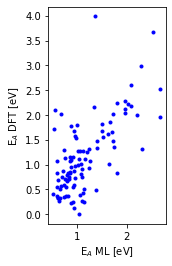

In [15]:
#plt.plot(X_test[key], rfr_pred, 'bo', label='predicted')
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(rfr_struct_pred, y_test_struct, 'b.')
plt.xlabel('E$_A$ ML [eV]')
plt.ylabel('E$_A$ DFT [eV]')
ax.set_aspect('equal')
plt.savefig('../teksti/images/rfr_struct_pred.png')
plt.show()